In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from einops import rearrange
import numpy as np
from torch import optim
from tqdm import tqdm
from PIL import Image
from IPython.display import Image as IPyImage, display
from io import BytesIO
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.models.feature_extraction import create_feature_extractor

### VIT Reference
Refer to (https://github.com/Ishushan02/Cervical-Cancer-Detection-Using-Vision-Transformer) for Vision Transformer block code

In [2]:
x = torch.arange(0, 32).view(2, 1, 4, 4) 
print(x)
patches = x.unfold(2, 2, 2).unfold(3, 2, 2)
print(patches)


tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]],


        [[[16, 17, 18, 19],
          [20, 21, 22, 23],
          [24, 25, 26, 27],
          [28, 29, 30, 31]]]])
tensor([[[[[[ 0,  1],
            [ 4,  5]],

           [[ 2,  3],
            [ 6,  7]]],


          [[[ 8,  9],
            [12, 13]],

           [[10, 11],
            [14, 15]]]]],




        [[[[[16, 17],
            [20, 21]],

           [[18, 19],
            [22, 23]]],


          [[[24, 25],
            [28, 29]],

           [[26, 27],
            [30, 31]]]]]])


In [3]:
class MakeVideoDataset(Dataset):
    def __init__(self, video, input_length=10, output_length=10):
        super().__init__()
        self.video = video
        self.input_length = input_length
        self.output_length = output_length
        self.batch_size, self.seq_len, _, _, _ = video.shape

        self.samples_per_video = self.seq_len - input_length - output_length + 1
        self.total_samples = self.batch_size * self.samples_per_video

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        batch_idx = idx // self.samples_per_video
        time_idx = idx % self.samples_per_video

        input_frames = self.video[batch_idx, time_idx:time_idx + self.input_length]
        output_frames = self.video[batch_idx, time_idx + self.input_length:time_idx + self.input_length + self.output_length]

        return (
            torch.tensor(input_frames, dtype=torch.float32),
            torch.tensor(output_frames, dtype=torch.float32)
        )

    
    
test = torch.randn(32, 20, 1, 4, 4)
out = MakeVideoDataset(test)
x, y = out.__getitem__(0)
x.shape, y.shape

/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_1512/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_1512/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)


(torch.Size([10, 1, 4, 4]), torch.Size([10, 1, 4, 4]))

In [4]:
class PatchEMbedding(nn.Module):
    def __init__(self, patchSize = 8, inChannels = 1, embed_dim = 256):
        super().__init__()
        self.patchSize = patchSize
        self.inChannels =inChannels
        self.embed_dim = embed_dim
        self.projection_layer = nn.Conv3d(
            in_channels=inChannels,
            out_channels=embed_dim,
            kernel_size=(1, patchSize, patchSize),
            stride=(1, patchSize, patchSize)
        )

    def forward(self, x):
        batch_size, timeFrame, channels, height, width = x.shape
        x = x.permute(0, 2, 1, 3, 4)

        x = self.projection_layer(x)
        # print("Patchs Shape: ", x.shape) 
        x = rearrange(x, 'b c t h w -> b t (h w) c')
        return x
    
test = torch.randn(20, 10, 1, 64, 64)
Pembed = PatchEMbedding()
out = Pembed(test)
out.shape


torch.Size([20, 10, 64, 256])

In [5]:
class VideoGenerator(nn.Module):
    def __init__(self, imageSize = 64, patchSize = 8, inChannels = 1, input_length = 10, output_length = 10, heads = 8, feedForwardDim = 1024, d_embed = 256):
        super().__init__()
                
        self.imageSize = imageSize
        self.patchSize = patchSize
        self.inChannels = inChannels
        self.input_length = input_length
        self.output_length = output_length
        self.d_embed = d_embed
        self.heads = heads
        self.patch_embedding = PatchEMbedding(patchSize=patchSize, inChannels=inChannels, embed_dim=d_embed)
        self.positional_embedding = nn.Parameter(torch.randn(1, input_length, patchSize * patchSize, d_embed))
        self.num_patches_per_frame = (self.imageSize // patchSize) ** 2 
        self.patches_per_side = self.imageSize // patchSize



        self.encoding_layer = nn.TransformerEncoderLayer(
            d_model=d_embed,
            nhead=heads,
            dim_feedforward=feedForwardDim,
            dropout=0.1,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(self.encoding_layer, num_layers=6)

        self.decoder = nn.Sequential(
            nn.Linear(d_embed, 4 * d_embed),
            nn.GELU(),
            nn.Linear(4 * d_embed, output_length * self.num_patches_per_frame * patchSize**2 * inChannels)
        )
        self.decoderout = nn.Sequential(
            nn.ConvTranspose2d(d_embed, 128, kernel_size=4, stride=2, padding=1),   # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),        # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, inChannels * output_length, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
        )


    def forward(self, x):
        batch_size, timeFrame, channels, height, width = x.shape

        x = self.patch_embedding(x) + self.positional_embedding
        # print(x.shape)

        x = rearrange(x, 'b t p d -> b (t p) d')

        # print(x.shape)
        x = self.encoder(x)

        # print(x.shape)
        x = rearrange(x, 'b (t p) d -> b t p d', t=self.input_length)  # [B, T, P, D]
        x_last = x[:, -1]  # [B, P=64, D=256]
        x_last = rearrange(x_last, 'b (h w) d -> b d h w', h=self.patches_per_side)  # [B, 256, 8, 8]

        pred = self.decoderout(x_last)  # [B, C*out_len, 64, 64]
        pred = pred.view(batch_size, self.output_length, self.inChannels, self.imageSize, self.imageSize)


        


        return pred
    
test = torch.randn(20, 10, 1, 64, 64)
VGen = VideoGenerator()
out = VGen(test)
out.shape

torch.Size([20, 10, 1, 64, 64])

In [6]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
data.shape

(20, 10000, 64, 64)

In [7]:
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
data.shape

torch.Size([10000, 20, 1, 64, 64])

In [8]:
class PerceptualLoss(nn.Module):
    def __init__(self, weight = 0.15):
        super().__init__()
        self.weight = weight
        self.vgg = vgg16(pretrained = True).features[:17].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        batch, timeframe, channels, height, width = pred.shape
        pred = rearrange(pred, 'b t c h w -> (b t) c h w')
        target = rearrange(target, 'b t c h w -> (b t) c h w')

        # pred = rearrange(pred, (batch*timeframe, channels, height, width))
        # target = rearrange(target, (batch*timeframe, channels, height, width))

        if pred.shape[1] == 1:
            pred = pred.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)


        vgg_pred = self.vgg(pred)
        vgg_true = self.vgg(target)

        perceptualoss = F.mse_loss(vgg_pred, vgg_true)
        mse_loss = self.mse(pred, target)

        return mse_loss + self.weight * perceptualoss
    

ttrue = torch.randn(1, 10, 1, 64, 64)
pred = torch.randn(1, 10, 1, 64, 64)
lsFn = PerceptualLoss(weight=0.15)
out = lsFn(pred, ttrue)
out.item()

/Users/ishananand/miniforge3/envs/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ishananand/miniforge3/envs/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


4.148749351501465

In [9]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
torchDataset = MakeVideoDataset(data)
dataloader = DataLoader(torchDataset, batch_size=32, shuffle = True)

model = VideoGenerator().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
# lossFn = nn.MSELoss()
lossFn = PerceptualLoss(weight=0.15)

epochs = 50

In [ ]:
modelLoad = torch.load("data/vit_model-2.pt")
model.load_state_dict(modelLoad)
for each_epoch in range(epochs):
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    lossVal = 0.0
    for batchX, batchY in loop:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        batchX = batchX/255.0
        batchY = batchY/255.0

        # print(batchX.shape, batchY.shape)
        pred = model(batchX)
        # print(pred.shape, batchY.shape)
    
        optimizer.zero_grad()
        loss = lossFn(pred, batchY)
        loss.backward()
        optimizer.step()

        lossVal += loss.item()

    avg_loss = lossVal/len(dataloader)
    print(f" The Loss is {avg_loss}")
    # loop.postfix()
    torch.save(model.state_dict(), "data/vit_model-2.pt")
    

        # break

    # break



0/50:   0%|          | 0/313 [00:00<?, ?it/s]/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_1432/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_1432/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)
0/50: 100%|██████████| 313/313 [58:50<00:00, 11.28s/it] 


 The Loss is 1.1642753041971226


1/50: 100%|██████████| 313/313 [1:00:43<00:00, 11.64s/it]


 The Loss is 1.1367016794582525


2/50: 100%|██████████| 313/313 [1:02:23<00:00, 11.96s/it]


 The Loss is 1.1130486658206


3/50: 100%|██████████| 313/313 [59:15<00:00, 11.36s/it]


 The Loss is 1.0912508039047923


4/50: 100%|██████████| 313/313 [1:00:36<00:00, 11.62s/it]


 The Loss is 1.0708724187966734


5/50: 100%|██████████| 313/313 [57:43<00:00, 11.07s/it]


 The Loss is 1.0520383334769228


6/50: 100%|██████████| 313/313 [57:21<00:00, 11.00s/it]


 The Loss is 1.0341837381402526


7/50: 100%|██████████| 313/313 [57:48<00:00, 11.08s/it]


 The Loss is 1.0209418407644326


8/50: 100%|██████████| 313/313 [57:23<00:00, 11.00s/it]


 The Loss is 1.0061936077599327


9/50: 100%|██████████| 313/313 [57:52<00:00, 11.09s/it]


 The Loss is 0.993214741682473


10/50: 100%|██████████| 313/313 [57:02<00:00, 10.94s/it]


 The Loss is 0.9816422451037569


11/50:  66%|██████▌   | 207/313 [1:04:35<21:01, 11.90s/it]   

In [17]:
modelVal = torch.load("data/vit_model-2.pt", map_location=torch.device('cpu'))
model.load_state_dict(modelVal)


<All keys matched successfully>

In [18]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
# data.shape
data = np.transpose(data, (1, 0, 2, 3))
# data = data.unsqueeze(2)
data.shape

(10000, 20, 64, 64)

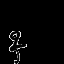

In [19]:
def visualizeData(sequence):

    frames = [Image.fromarray((frame * 255).astype(np.uint8), mode='L') for frame in sequence]

    buffer = BytesIO()
    frames[0].save(
        buffer,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )

    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

visualizeData(data[11])

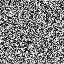

In [23]:
def generateVideos(model, initialFrame):

    all_outputs = []

    test = initialFrame.float().unsqueeze(0).unsqueeze(0).unsqueeze(2)  

    for _ in range(2):
        out = model(test)
        # print(out.shape)
        temp = out * 255.0
        all_outputs.append(temp)
        last_frame = out[:, -1, :, :]
        test = last_frame.unsqueeze(1)
        # print(test.shape)

    full_output = torch.cat(all_outputs, dim=1)
    full_output = full_output.squeeze(2)
    # print(full_output.shape)
    numpy_data = full_output.detach().cpu().numpy()
    visualizeData(numpy_data[0])

initial_frame = torch.from_numpy(data[0, 5]/255.0)
generateVideos(model, initial_frame)
#350